In [25]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from dotenv import load_dotenv

In [26]:
load_dotenv()

True

In [27]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description="The sentiment of the review, either 'positive' or 'negative'.")
    
class DiagnosisSchema(BaseModel):
    issue_type: Literal['UX', 'Performance', 'Bug', 'Support', 'Other'] = Field(description="The type of issue mentioned in the review.")
    tone: Literal['angry', 'frustrated', 'disappointed', 'neutral'] = Field(description="The tone of the review.")
    urgency: Literal['low', 'medium', 'high'] = Field(description="The urgency of the issue mentioned in the review.")

In [28]:
sentiment_model = ChatOpenAI(model = 'gpt-4o-mini').with_structured_output(SentimentSchema)
diagnosis_model = ChatOpenAI(model = 'gpt-4o-mini').with_structured_output(DiagnosisSchema)
model = ChatOpenAI(model = 'gpt-4o-mini')

In [29]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive', 'negative']
    diagnosis: dict
    response: str

In [32]:
def find_sentiment(state: ReviewState):
    prompt = f"Analyze the following review and determine if the sentiment is positive or negative:\n\n{state['review']}"
    sentiment = sentiment_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}

def diagnose_issue(state: ReviewState):
    prompt = f"Diagnose this negative review : \n\n{state['review']}. Return issue_type, tone, and urgency"
    response = diagnosis_model.invoke(prompt)
    return {'diagnosis': response.model_dump()}

def positive_response(state: ReviewState):
    prompt = f"Generate a positive response to the following review:\n\n{state['review']}"
    response = model.invoke(prompt).content
    return {'response': response}

def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']
    prompt = f"You are a support assistant, the user had a {diagnosis['issue_type']} issue with tone {diagnosis['tone']} and urgency {diagnosis['urgency']}. Generate a helpful response."
    response = model.invoke(prompt).content
    return {'response': response}

def check_sentiment(state: ReviewState) -> Literal['positive_response', 'diagnose_issue']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'diagnose_issue'

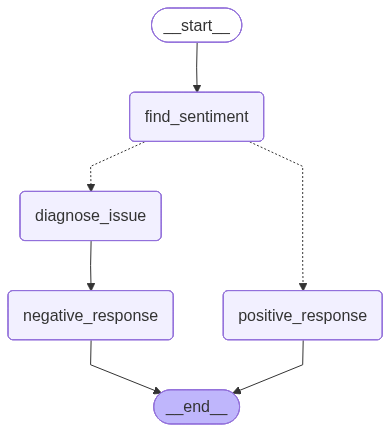

In [33]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('diagnose_issue', diagnose_issue)
graph.add_node('positive_response', positive_response)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')
graph.add_conditional_edges('find_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('diagnose_issue', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

workflow

In [34]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
workflow.invoke(intial_state)

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'response': "Subject: Resolving Your Bug Issue\n\nHi [User's Name],\n\nI understand how frustrating it can be to deal with a bug, especially when you’re relying on it for important tasks. I’m here to help you get this resolved as quickly as possible.\n\nCould you please provide me with a few details about the issue? Specifically, it would be helpful to know:\n\n1. A brief description of the bug you’re encountering.\n2. Any error messages you’ve received.\n3. The steps you took leading up to the issue.\n4. Your device type and operating system version.\n\nOnce I have this information, I can investigate further and work towards a solution. Than